# Treated and Untreated Distributions Induced by the Learned Representation

In [1]:
from models import *
from train import *
import tensorflow as tf
import keras.backend as K
from keras.engine.topology import Layer
from keras.metrics import binary_accuracy
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout, Reshape, Lambda
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
import numpy as np 
from sklearn.model_selection import train_test_split
import glob
from sklearn.metrics import classification_report , f1_score , log_loss, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import copy 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import math 
from scipy.stats import wasserstein_distance

2021-09-16 14:16:55.497498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data 

In [2]:
train_cv = np.load(os.path.join('datasets/IHDP/','ihdp_npci_1-1000.train.npz'))
test =     np.load(os.path.join('datasets/IHDP/','ihdp_npci_1-1000.test.npz'))
    
    
X_tr    = train_cv.f.x.copy()
T_tr    = train_cv.f.t.copy()
YF_tr   = train_cv.f.yf.copy()
YCF_tr  = train_cv.f.ycf.copy()
mu_0_tr = train_cv.f.mu0.copy()
mu_1_tr = train_cv.f.mu1.copy()

X_te    = test.f.x.copy()
T_te    = test.f.t.copy()
YF_te   = test.f.yf.copy()
YCF_te  = test.f.ycf.copy()
mu_0_te = test.f.mu0.copy()
mu_1_te = test.f.mu1.copy()

#X = np.concatenate([X_tr,X_te],axis=0)
T = np.concatenate([T_tr,T_te],axis=0)
YF = np.concatenate([YF_tr,YF_te],axis=0)
YCF = np.concatenate([YCF_tr,YCF_te],axis=0)
mu_0_all = np.concatenate([mu_0_tr,mu_0_te],axis=0)
mu_1_all = np.concatenate([mu_1_tr,mu_1_te],axis=0)

idx=0

print("++++",idx,"/",X_tr.shape[-1]-1)

t_tr, y_tr, x_tr, mu0tr, mu1tr = T_tr[:,idx] , YF_tr[:,idx], X_tr[:,:,idx], mu_0_tr[:,idx], mu_1_tr[:,idx] 
t_te, y_te, x_te, mu0te, mu1te = T_te[:,idx] , YF_te[:,idx], X_te[:,:,idx], mu_0_te[:,idx], mu_1_te[:,idx]  

++++ 0 / 999


## Training DragonBalSS

In [3]:
test_outputs, train_output = train_and_predict_dragonbalss(t_tr, y_tr, x_tr, mu0tr, mu1tr,
                                                           t_te, y_te, x_te, mu0te, mu1te,
                                                           output_dir='.',
                                                           ratio=1.0, 
                                                           val_split=0.22, 
                                                           b_ratio=1.0,
                                                           use_targ_term=False,
                                                           use_bce=False, 
                                                           act_fn='relu',
                                                           optim='sgd',
                                                           momentum=0.9,
                                                           lr=1e-5,
                                                           norm_bal_term=True,
                                                           bs_ratio=1.0)

>> I am dragonbalss...


2021-09-16 14:16:57.947062: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-16 14:16:57.948365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-16 14:16:58.218423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1e:00.0 name: Tesla V100-SXM3-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 913.62GiB/s
2021-09-16 14:16:58.218467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-16 14:16:58.220761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-09-16 14:16:58.220852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-16 14:16:59.997943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-16 14:17:00.002042: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2700000000 Hz


2021-09-16 14:17:00.857144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


***************************** elapsed_time is:  17.693164587020874
TEST: average propensity for treated: 0.4870637059211731 and untreated: 0.4877580404281616
TRAIN: average propensity for treated: 0.4888345003128052 and untreated: 0.4888451397418976


## Treated vs. Untreated Distributions 

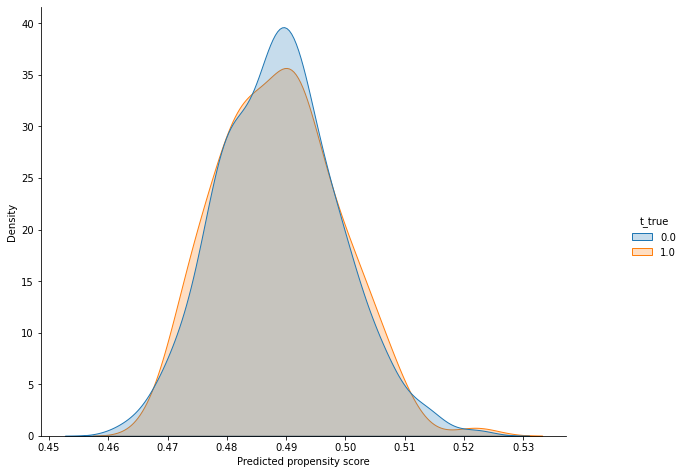

In [4]:
test_data =np.concatenate([test_outputs[0]['g'].reshape([-1,1]),test_outputs[0]['t'].reshape([-1,1])],axis=1)
train_data =np.concatenate([ train_output[0]['g'].reshape([-1,1]), train_output[0]['t'].reshape([-1,1])],axis=1)
data=np.concatenate([train_data,test_data],axis=0)

split = np.array(['Train']*len(train_output[0]['g'])+['Test']*len(test_outputs[0]['g'])).reshape([-1,1])
adf = pd.DataFrame(np.concatenate([data,split],axis=1),columns=['t_pred','t_true','split'])
adf["t_pred"] = pd.to_numeric(adf["t_pred"])
adf["t_true"] = pd.to_numeric(adf["t_true"])

g = sns.displot(adf, x="t_pred", hue="t_true", kind="kde", fill=True, common_norm=False)
g.fig.set_size_inches(10,7)
g.set_axis_labels("Predicted propensity score","Density")

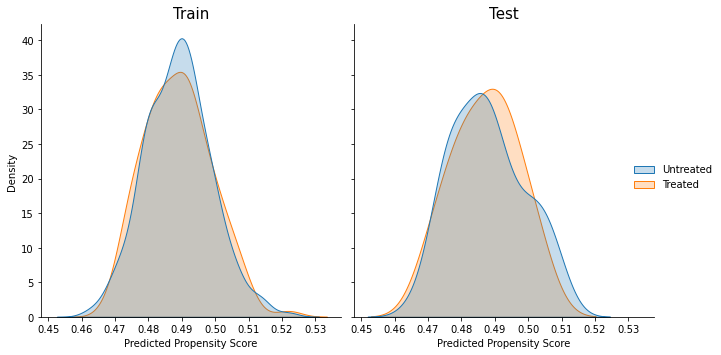

In [5]:
g = sns.displot(adf, x="t_pred", hue="t_true", col='split', kind="kde", fill=True, common_norm=False)
plt.rcParams["axes.labelsize"] = 15
g.fig.set_size_inches(10,5)
g.set_axis_labels("Predicted Propensity Score","Density")
g.set_titles("{col_name}")
g._legend.set_title("")
new_labels = ['Untreated', 'Treated']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [6]:
def compute_distance(train_output,test_outputs):
        test_data =np.concatenate([test_outputs[0]['g'].reshape([-1,1]),test_outputs[0]['t'].reshape([-1,1])],axis=1)
        train_data =np.concatenate([ train_output[0]['g'].reshape([-1,1]), train_output[0]['t'].reshape([-1,1])],axis=1)
        data=np.concatenate([train_data,test_data],axis=0)
        split = np.array(['Train']*len(train_output[0]['g'])+['Test']*len(test_outputs[0]['g'])).reshape([-1,1])
        adf = pd.DataFrame(np.concatenate([data,split],axis=1),columns=['t_pred','t_true','split'])
        adf["t_pred"] = pd.to_numeric(adf["t_pred"])
        adf["t_true"] = pd.to_numeric(adf["t_true"])
        ###### TRAIN 
        treated   = adf[(adf["split"]=='Train') & (adf["t_true"]==0.0)]["t_pred"].tolist()
        untreated = adf[(adf["split"]=='Train') & (adf["t_true"]==1.0)]["t_pred"].tolist()
        # wass_train 
        wass_train = wasserstein_distance(treated, untreated)
        print("TRAIN - Wasserstein distance between learned treated and untreated distributions::",wass_train)
        ###### TEST
        treated   = adf[(adf["split"]=='Test') & (adf["t_true"]==0.0)]["t_pred"].tolist()
        untreated = adf[(adf["split"]=='Test') & (adf["t_true"]==1.0)]["t_pred"].tolist()
        # wass_train 
        wass_test = wasserstein_distance(treated, untreated)
        print("TEST - Wasserstein distance between learned treated and untreated distributions::",wass_test)
        
compute_distance(train_output,test_outputs)

TRAIN - Wasserstein distance between learned treated and untreated distributions:: 0.0007285530423333471
TEST - Wasserstein distance between learned treated and untreated distributions:: 0.0021355617660549354
